In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings( "ignore", module = "seaborn\..*" )

import sidetable
import statsmodels.api as sm
import pylab as py
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, StandardScaler,OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder 

In [2]:
vinos = pd.read_csv('vinos.csv', index_col= 0).reset_index()
vinos.head(10)

,winery,wine,year,rating,num_reviews,country,region,price,type,body,acidity
0,Teso La Monja,Tinto,2013,4.9,58,Espana,Toro,995.00,Toro Red,5.0,3.0
1,Artadi,Vina El Pison,2018,4.9,31,Espana,Vino de Espana,313.50,Tempranillo,4.0,2.0
2,Vega Sicilia,Unico,2009,4.8,1793,Espana,Ribera del Duero,324.95,Ribera Del Duero Red,5.0,3.0
3,Vega Sicilia,Unico,1999,4.8,1705,Espana,Ribera del Duero,692.96,Ribera Del Duero Red,5.0,3.0
4,Vega Sicilia,Unico,1996,4.8,1309,Espana,Ribera del Duero,778.06,Ribera Del Duero Red,5.0,3.0
5,Vega Sicilia,Unico,1998,4.8,1209,Espana,Ribera del Duero,490.00,Ribera Del Duero Red,5.0,3.0
6,Vega Sicilia,Unico,2010,4.8,1201,Espana,Ribera del Duero,349.00,Ribera Del Duero Red,5.0,3.0
7,Vega Sicilia,Unico,1995,4.8,926,Espana,Ribera del Duero,810.89,Ribera Del Duero Red,5.0,3.0
8,Vega Sicilia,Unico Reserva Especial Edicion,2015,4.8,643,Espana,Ribera del Duero,345.00,Ribera Del Duero Red,5.0,3.0
9,Vega Sicilia,Unico,2011,4.8,630,Espana,Ribera del Duero,315.00,Ribera Del Duero Red,5.0,3.0


#### 1. Toma únicamente las variables de tipo numérico del dataset.

In [3]:
vinos_numericas = vinos.select_dtypes(exclude = 'object')
vinos_numericas.head(2)

,rating,num_reviews,price,body,acidity
0,4.9,58,995.0,5.0,3.0
1,4.9,31,313.5,4.0,2.0


- Realiza un EDA explicando algunas de las cosas interesantes del conjunto de datos.

In [4]:
vinos_numericas.describe().round(1)

,rating,num_reviews,price,body,acidity
count,7500.0,7500.0,7500.0,6331.0,6331.0
mean,4.3,451.1,60.1,4.2,2.9
std,0.1,723.0,150.4,0.6,0.2
min,4.2,25.0,5.0,2.0,1.0
25%,4.2,389.0,18.9,4.0,3.0
50%,4.2,404.0,28.5,4.0,3.0
75%,4.2,415.0,51.4,5.0,3.0
max,4.9,32624.0,3119.1,5.0,3.0


In [5]:
vinos_numericas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   rating       7500 non-null   float64
 1   num_reviews  7500 non-null   int64  
 2   price        7500 non-null   float64
 3   body         6331 non-null   float64
 4   acidity      6331 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 293.1 KB


<font color ='violet'> Valores faltantes

In [11]:
vinos_numericas_missing = vinos_numericas.isnull().sum() * 100 / len(vinos) 
vinos_numericas_missing 

rating         0.0
num_reviews    0.0
price          0.0
body           0.0
acidity        0.0
dtype: float64

<font color ='violet'> Duplicados

In [7]:
vinos_numericas.duplicated().sum() 

5452

In [8]:
vinos_numericas.drop_duplicates(inplace= True)
vinos_numericas.duplicated().sum() 


/home/lcp87/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


0

<font color ='violet'>Decidimos eliminar los valores nulos porque no afectan al resultado final de nuestra correlación y nuestra pregunta.

In [9]:
vinos_numericas.dropna(inplace = True)

In [10]:
vinos_numericas.isna().sum()

rating         0
num_reviews    0
price          0
body           0
acidity        0
dtype: int64

<font color ='violet'> Outliers

In [12]:
def detectar_outliers(lista_columnas, df): 
    
    dicc_indices = {} # creamos un diccionario donde almacenaremos índices de los outliers
    
    # iteramos por la lista de las columnas numéricas de nuestro dataframe
    for col in lista_columnas:
        
        #calculamos los cuartiles Q1 y Q3
        Q1 = np.nanpercentile(df[col], 25)
        Q3 = np.nanpercentile(df[col], 75)
        
        # calculamos rango intercuartil
        IQR = Q3 - Q1
        
        # calculamos los límites
        outlier_step = 1.5 * IQR
        
        # filtramos nuestro df para indentificar los outliers
        outliers_data = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)]
        
        
        if outliers_data.shape[0] > 0: # chequeamos si nuestro df tiene alguna fila. 
        
            dicc_indices[col] = (list(outliers_data.index)) # si tiene fila es que hay outliers y por lo tanto lo añadimos a nuestro diccionario
        
    return dicc_indices 

In [13]:
vinos_numericas.columns

Index(['rating', 'num_reviews', 'price', 'body', 'acidity'], dtype='object')

In [14]:
lista_columnas = list(vinos_numericas.columns)

ind = detectar_outliers(lista_columnas, vinos)
# vemos que es lo que nos ha devuelto la función
for key, values in ind.items():
    print('Para la variable ' + key  + ' tenemos ' + str(len(values)) +' valores outliers,  esto es un ' + str(round(len(values)/vinos.shape[0]*100)) + '%\ de los datos' )

Para la variable rating tenemos 1821 valores outliers,  esto es un 24%\ de los datos
Para la variable num_reviews tenemos 1920 valores outliers,  esto es un 26%\ de los datos
Para la variable price tenemos 538 valores outliers,  esto es un 7%\ de los datos
Para la variable body tenemos 34 valores outliers,  esto es un 0%\ de los datos
Para la variable acidity tenemos 303 valores outliers,  esto es un 4%\ de los datos


In [15]:
def detectar_outliers(lista_columnas, df): 
    
    dicc_indices = {} # creamos un diccionario donde almacenaremos índices de los outliers
    
    # iteramos por la lista de las columnas numéricas de nuestro dataframe
    for col in lista_columnas:
        
        #calculamos los cuartiles Q1 y Q3
        Q1 = np.nanpercentile(df[col], 25)
        Q3 = np.nanpercentile(df[col], 75)
        
        # calculamos rango intercuartil
        IQR = Q3 - Q1
        
        # calculamos los límites
        outlier_step = 1.5 * IQR
        
        # filtramos nuestro df para indentificar los outliers
        outliers_data = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)]
        
        
        if outliers_data.shape[0] > 0: # chequeamos si nuestro df tiene alguna fila. 
        
            dicc_indices[col] = (list(outliers_data.index)) # si tiene fila es que hay outliers y por lo tanto lo añadimos a nuestro diccionario
        
    return dicc_indices 

In [16]:
vinos.columns

Index(['winery', 'wine', 'year', 'rating', 'num_reviews', 'country', 'region',
       'price', 'type', 'body', 'acidity'],
      dtype='object')

In [ ]:
lista_columnas = list(vinos.columns)

ind = detectar_outliers(lista_columnas, vinos)
# vemos que es lo que nos ha devuelto la función
for key, values in ind.items():
    print('Para la variable ' + key  + ' tenemos ' + str(len(values)) +' valores outliers,  esto es un ' + str(round(len(values)/vinos.shape[0]*100)) + '%\ de los datos' )

 - Obtén la matriz de correlacion de las variables y estudia los resultados explicando las diferentes correlaciones con las variables.

In [18]:
mask = np.triu(np.ones_like(vinos_numericas.corr(), dtype=np.bool));


/tmp/ipykernel_1243/3395958517.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(vinos_numericas.corr(), dtype=np.bool));


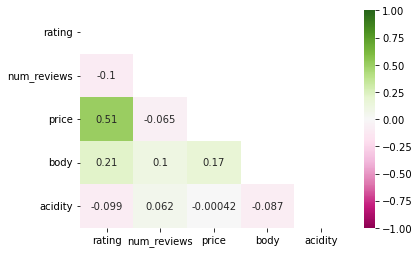

In [16]:
sns.heatmap(vinos_numericas.corr(), cmap = "PiYG", mask = mask, annot = True , vmin=-1, vmax=1 ); #definimos los valores máximos de 1 y -1 para que se vea bien la representación de los valores.

<font color ='violet'>Podemos ver en el heatmap que `price` y `rating` con las variables con la correlación más fuerte, mientras que el resto están muy cerca del cero, por lo que su correlación es bastante débil.

 - Limpia los datos de trabajo en caso de que sea necesario.

<font color ='violet'> No creemos que sea necesario limpiar el DataFrame ya que los datos están muy limpios y ordenados. Destacamos el valor N.V. en la columna `year` pero al estar en tipo 'object' no nos afecta.

 - Realiza el ajuste lineal múltiple mostrando las métricas.

In [19]:
x = vinos_numericas.drop(columns = ['price'])
y = vinos_numericas['price']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

# Creamos la regresión lineal
LR = LinearRegression() # nos aseguramos de que se normalizan los datos
# Ajustamos el modelo
LR.fit(x_train,y_train)
y_prediction_train =  LR.predict(x_train)
Adj_r2_train = 1 - (1-r2_score(y_train,y_prediction_train)) * (x_train.shape[0]-1)/(x_train.shape[0]-x_train.shape[1]-1)

y_prediction =  LR.predict(x_test)
Adj_r2_test = 1 - (1-r2_score(y_test, y_prediction)) * (x_test.shape[0]-1)/(x_test.shape[0]-x_test.shape[1]-1)

# Para el conjunto de entrenamiento las métricas han sido
print('Para el conjunto train:---------------')
print('El valor de r2 score es ',r2_score(y_train,y_prediction_train))
print('El valor de r2 score adjusted es ',Adj_r2_train)
print('El MAE es',mean_absolute_error(y_train,y_prediction_train))
print('EL RMSE es ',np.sqrt(mean_squared_error(y_train,y_prediction_train)))


# Para el conjunto de test las métricas han sido
print('Para el conjunto test:---------------')
print('El valor de r2 score es ',r2_score(y_test,y_prediction))
print('El valor de r2 score adjusted es ',Adj_r2_test)
print('El MAE es',mean_absolute_error(y_test,y_prediction))
print('EL RMSE es ',np.sqrt(mean_squared_error(y_test,y_prediction)))

Para el conjunto train:---------------
El valor de r2 score es  0.2819620645647941
El valor de r2 score adjusted es  0.27993370881497714
El MAE es 135.47946117895592
EL RMSE es  249.626560993348
Para el conjunto test:---------------
El valor de r2 score es  0.16790602671400678
El valor de r2 score adjusted es  0.1584234743118872
El MAE es 133.24888122722663
EL RMSE es  242.36175557838843


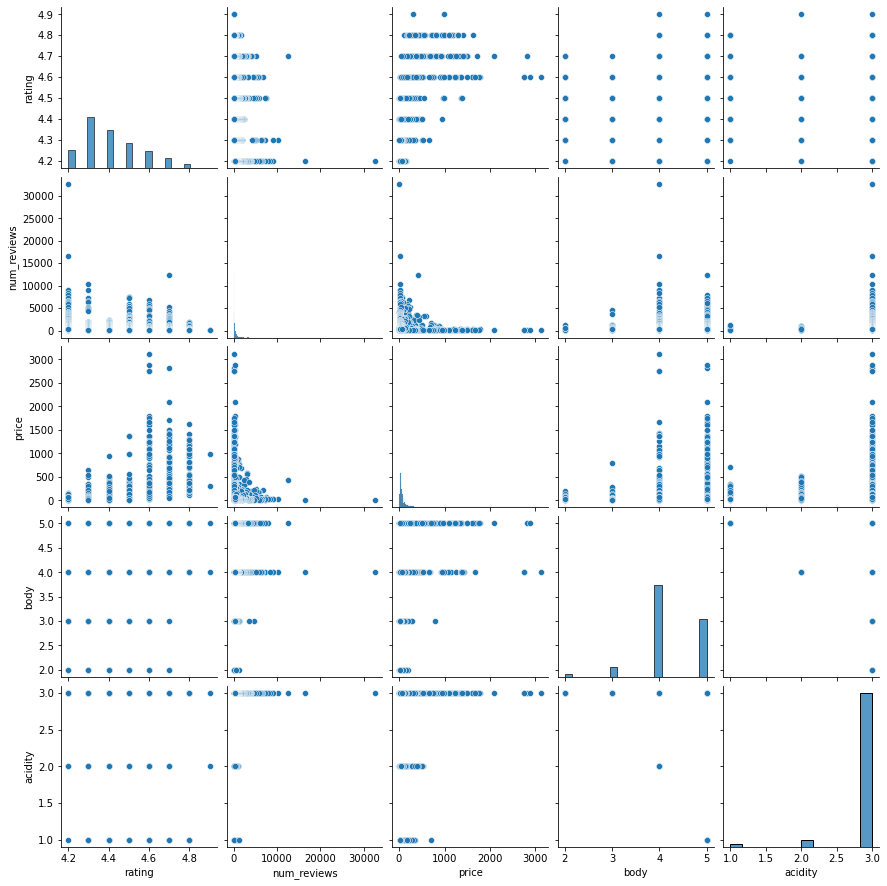

In [20]:
sns.pairplot(vinos_numericas);

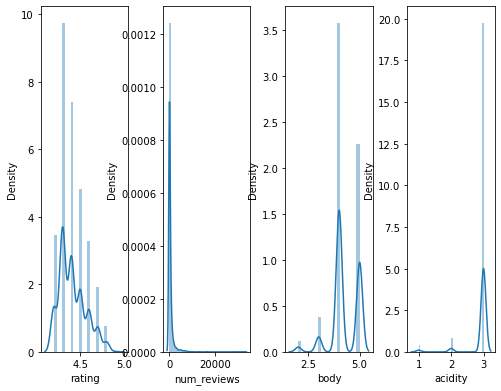

In [24]:
data_plot=vinos_numericas.drop(['price'],axis=1) 
plt.figure(figsize=(10,6)) 
for idx, value in enumerate(data_plot.columns): 
    plt.subplot(1,5,idx+1) 
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4) 
    sns.distplot(data_plot[value]);

<font color ='violet'> Podemos observar que nuestros datos no son normales ya que no vemos que su distribución sea parecida a la campana de Gauss.

#### 2. Toma ahora el dataset incluyendo las variables categóricas.

In [27]:
categoricas = vinos.select_dtypes(include = "object")
categoricas.head() 

,winery,wine,year,country,region,type
0,Teso La Monja,Tinto,2013,Espana,Toro,Toro Red
1,Artadi,Vina El Pison,2018,Espana,Vino de Espana,Tempranillo
2,Vega Sicilia,Unico,2009,Espana,Ribera del Duero,Ribera Del Duero Red
3,Vega Sicilia,Unico,1999,Espana,Ribera del Duero,Ribera Del Duero Red
4,Vega Sicilia,Unico,1996,Espana,Ribera del Duero,Ribera Del Duero Red


 - Realiza el EDA de las variables categóricas que se va a incluir en el modelo.

In [25]:
for col in ['region','type','wine', 'year']:
    print('\n')
    print(f"En la columna {col} tenemos los siguientes valores unicos:")
    print(vinos[col].value_counts())



En la columna region tenemos los siguientes valores unicos:
Rioja                              2440
Ribera del Duero                   1413
Priorato                            686
Toro                                300
Vino de Espana                      263
                                   ... 
Ribera del Gallego-Cinco Villas       1
Monterrei                             1
Jerez Cream                           1
Condado de Huelva                     1
Abona                                 1
Name: region, Length: 76, dtype: int64


En la columna type tenemos los siguientes valores unicos:
Rioja Red               2357
Ribera Del Duero Red    1407
Red                      864
Priorat Red              674
Toro Red                 296
Tempranillo              291
Sherry                   274
Albarino                 252
Mencia                   235
Rioja White               92
Pedro Ximenez             35
Grenache                  35
Cava                      33
Verdejo               

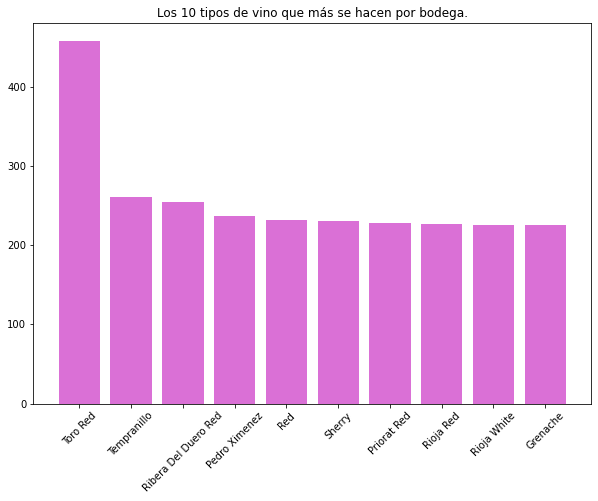

In [28]:
x= vinos['type'].unique()[:10]
y = vinos['winery'].value_counts()[:10]

plt.figure()
plt.xticks(rotation= 45)
plt.title('Los 10 tipos de vino que más se hacen por bodega.')
plt.bar(x,y, color ='orchid')
plt.gcf().set_size_inches(10, 7)

<font color = 'violet'> En esta gráfica mostramos los 10 tipo de vino que más se produce en función de la cantidad de bodegas.

 - Utiliza algun tipo de codificación para las variables numéricas.

In [29]:
vinos_encoded = categoricas.copy()

# iniciamos el método
le = LabelEncoder()

# lo aplicamos a todo nuestro dataframe 
for col in vinos_encoded.select_dtypes(include='object').columns:
    vinos_encoded[col]=le.fit_transform(vinos_encoded[col])

In [30]:
vinos_encoded.head()

,winery,wine,year,country,region,type
0,422,759,61,0,69,19
1,33,819,66,0,74,18
2,447,778,57,0,57,11
3,447,778,47,0,57,11
4,447,778,44,0,57,11


In [34]:
vinos_encoded = vinos_encoded.drop(columns="country")

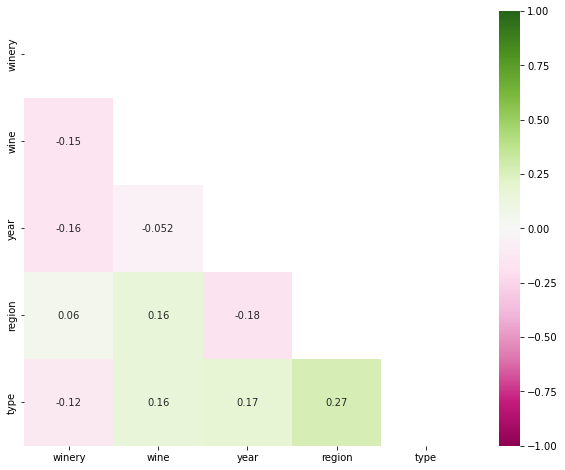

In [36]:
fig, ax = plt.subplots(figsize = (10,8))
corr = vinos_encoded.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr,mask = mask,xticklabels=corr.columns.values,yticklabels=corr.columns.values, cmap = "PiYG", vmin=-1, vmax=1,annot= True );

 - Realiza la misma limpieza de datos, en caso necesario, aplicada en el dataset del apartado para dejar las variables numéricas limpias.

<font color = 'violet'> Al igual que con las variables numéricas, no consideramos necesario realizar ninguna limpieza ya que nuestro dataframe está muy limpio y claro.

 - Obten el ajuste lineal múltiple incluyendo las variables categóricas

In [38]:
x= vinos_encoded.drop(columns = ['type'])
y = vinos_encoded['type']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

LR = LinearRegression()
LR.fit(x_train,y_train)
y_prediction_train =  LR.predict(x_train)
Adj_r2_train = 1 - (1-r2_score(y_train,y_prediction_train)) * (x_train.shape[0]-1)/(x_train.shape[0]-x_train.shape[1]-1)

y_prediction =  LR.predict(x_test)
Adj_r2_test = 1 - (1-r2_score(y_test, y_prediction)) * (x_test.shape[0]-1)/(x_test.shape[0]-x_test.shape[1]-1)

print('Para el conjunto train:---------------')
print('El valor de r2 score es ',r2_score(y_train,y_prediction_train))
print('El valor de r2 score adjusted es ',Adj_r2_train)
print('El MAE es',mean_absolute_error(y_train,y_prediction_train))
print('EL RMSE es ',np.sqrt(mean_squared_error(y_train,y_prediction_train)))

print('Para el conjunto test:---------------')
print('El valor de r2 score es ',r2_score(y_test,y_prediction))
print('El valor de r2 score adjusted es ',Adj_r2_test)
print('El MAE es',mean_absolute_error(y_test,y_prediction))
print('EL RMSE es ',np.sqrt(mean_squared_error(y_test,y_prediction)))

Para el conjunto train:---------------
El valor de r2 score es  0.15144865973042032
El valor de r2 score adjusted es  0.15088248702632046
El MAE es 2.6681331043833723
EL RMSE es  4.010684406654044
Para el conjunto test:---------------
El valor de r2 score es  0.1263634338637324
El valor de r2 score adjusted es  0.12402594472356843
El MAE es 2.6923521247070052
EL RMSE es  4.057024098266681


<font color = 'violet'> El valor que nos ha dado R2 es muy bajo, por lo que podemos afirmar que el ajuste linear no es demasiado bueno.